In [151]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from koopman.simulation.animation import PlotEnvironment
from koopman.simulation.systems import DynamicalSystem, Pendulum
from koopman.simulation.simulator import simulate, simulate_batch
from IPython.display import HTML
import einops
from spatialmath.base import angle_wrap

In [152]:
def reconstruct_from_pendulum_observables(observable, C):
    if len(observable.shape) == 1:
        observable = observable.reshape((1, observable.shape[0]))
    
    xs = einops.einsum(observable, C, 'n z, x z->n x')
    return xs.squeeze()

def compute_Cx(nx, nz):
    C = np.zeros((nx, nz))
    C[:, :nx] = np.eye(nx)
    return C

Cx = compute_Cx(Pendulum.nx, Pendulum.nz)

In [153]:
# Constants
g = 9.81      # gravity
l = 1.0       # length
m = 1.0       # mass
dt = 0.02     # timestep
tf = 10.0
N = int(tf / dt)  # number of timesteps
nx = Pendulum.nz
nu = Pendulum.nu

# Cost matrices
Q = np.diag([1.0, 0.1])  # State cost
R = np.diag([0.01])                  # Control cost
Qf = 1e2 * Q                         # Terminal cost
x0_val = np.array([0.0, 0.0])
xf_val = np.array([np.pi, 0.0])
z0_val = Pendulum.koopman_observables(x0_val)
zf_val = Pendulum.koopman_observables(xf_val)

assert np.allclose(Cx @ z0_val, x0_val)

K = np.array(
    [[0.9999999754388059, 0.02000006177563539, 7.654264784148768e-08, -0.001959793633902955, 8.814579943554335e-09, 2.3136130730206164e-08, -1.308709914083197e-05], [-4.615262483682924e-06, 1.0000116891176876, 1.4430846123200322e-05, -0.19575950513867385, 1.6962920426129985e-06, 4.6213264527355125e-06, -0.00196070509007737], [4.815077373279686e-16, -2.688042117452577e-16, 0.999999999999996, -3.19683786820929e-16, -2.1217836515541322e-16, -5.899753884215653e-17, 2.5804011705155006e-16], [6.603353519547839e-05, -0.0001653440541213597, -0.0002072415043863465, 0.9932764433991664, -2.4954183667323973e-05, -7.057801981613475e-05, 0.019939157880109144], [1.3341511254674664e-06, -1.0999920392254972e-06, 0.001357763544282738, -1.9966632747375334e-05, 0.9933267730237219, -0.019882413356017627, -7.168517150430593e-05], [-0.00014153409256537075, 0.00013315691787880448, -0.135829622984069, 0.0019680391863941315, 0.6662890936085548, 0.9804992342335839, 0.007148940528740381], [0.00569119967698925, -0.013839764088167738, -0.018026878319292568, -0.6694015165408743, -0.002296395060266953, -0.00703093108173754, 0.9857164415512795]]
)
B = np.array(
    [[0.00019989255930311393], [0.019979102802734353], [1.786900705527672e-16], [0.0003104632169429568], [-3.584139699708591e-05], [0.0036116036827562783], [0.029214249800236923]]
)

def dynamics(z, u):
    return K @ z + B @ u


In [154]:
X = ca.MX.sym('X', nx, N + 1)
U = ca.MX.sym('U', nu, N)

cost = 0
ineq = []

for k in range(N):
    xk = X[:, k]
    uk = U[:, k]
    xk_next = X[:, k+1]

    # Stage cost
    xkerr = Cx @ xk - xf_val
    cost += ca.mtimes([xkerr.T, Q, xkerr])
    cost += ca.mtimes([uk.T, R, uk])

    # Dynamics constraint
    xk_next_pred = K @ xk + B @ uk
    ineq.append(xk_next - xk_next_pred)

# Terminal cost
xNerr = Cx @ X[:, N] - xf_val
cost += ca.mtimes([xNerr.T, Qf, xNerr])

# Initial condition constraint
ineq.insert(0, X[:, 0] - z0_val)

ineq_flat = ca.vertcat(*ineq)

# Define decision variables
opt_vars = ca.vertcat(
    ca.reshape(X, nx * (N + 1), 1),
    ca.reshape(U, nu * N, 1)
)

In [155]:
# Create NLP
nlp = {'x': opt_vars, 'f': cost, 'g': ineq_flat}

# Solver
solver = ca.nlpsol('solver', 'ipopt', {'x': opt_vars, 'f': cost, 'g': ineq_flat},
                   {'ipopt.print_level': 0, 'print_time': 1})

# Initial guess
x0_guess = np.tile(np.zeros((nx, 1)), (N+1, 1))
u0_guess = 1e-2 * np.random.randn(nu, N)
x0u0 = np.concatenate([x0_guess.flatten(), u0_guess.flatten()])

lbg = ubg = np.zeros(ineq_flat.shape)

x_min = -ca.inf * np.ones((nx, N + 1))
x_max = ca.inf * np.ones((nx, N + 1))
u_min = -3.0 * np.ones((nu, N))
u_max = 3.0 * np.ones((nu, N))

lbx = np.concatenate([x_min.flatten(), u_min.flatten()])
ubx = np.concatenate([x_max.flatten(), u_max.flatten()])

sol = solver(x0=x0u0, lbg=lbg, ubg=ubg, lbx=lbx, ubx=ubx)

stats = solver.stats()
print(f"Solver statistics:")
print(f"\titer_count: {stats['iter_count']}")
print(f"\treturn_status: {stats['return_status']}")

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.41ms (100.36us)   1.40ms (100.32us)        14
       nlp_g  |   1.78ms (127.36us)   1.74ms (124.46us)        14
  nlp_grad_f  |   2.74ms (182.53us)   2.73ms (182.33us)        15
  nlp_hess_l  |  13.54ms (  1.04ms)  13.52ms (  1.04ms)        13
   nlp_jac_g  |   8.16ms (544.33us)   8.21ms (547.10us)        15
       total  |  74.74ms ( 74.74ms)  76.26ms ( 76.26ms)         1
Solver statistics:
	iter_count: 13
	return_status: Solve_Succeeded


(501, 7)
(501, 2)


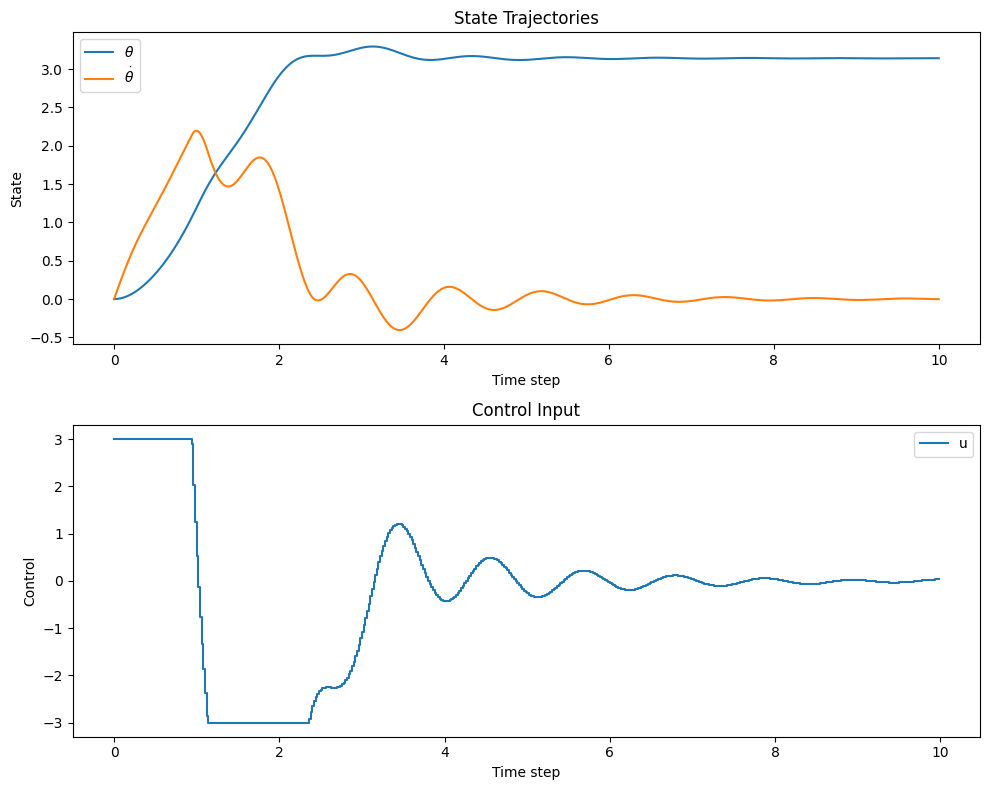

In [156]:
opt = sol['x'].full().flatten()
Z_opt = opt[:nx*(N+1)].reshape((N+1, nx))
print(Z_opt.shape)

X_opt = reconstruct_from_pendulum_observables(Z_opt, Cx)
print(X_opt.shape)

U_opt = opt[nx*(N+1):].reshape((N, nu))

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ts = np.arange(0, tf + dt, dt)

ax[0].plot(ts, Z_opt[:, 0], label=r'$\theta$')
ax[0].plot(ts, Z_opt[:, 1], label=r'$\dot{\theta}$')
ax[0].set_title('State Trajectories')
ax[0].set_xlabel('Time step')
ax[0].set_ylabel('State')
ax[0].legend()

ax[1].step(ts[:-1], U_opt[:, 0], label='u', where='post')
ax[1].set_title('Control Input')
ax[1].set_xlabel('Time step')
ax[1].set_ylabel('Control')
ax[1].legend()

plt.tight_layout()
plt.show()

Simulation progress: 100%|██████████| 500/500 [00:00<00:00, 30290.34it/s]


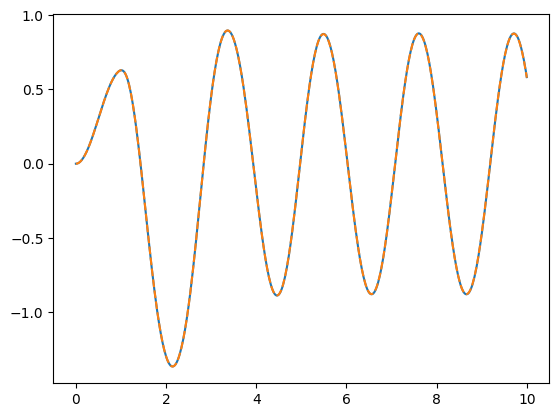

In [198]:
pendulum = Pendulum(Pendulum.Params(g=g, l=l, m=m))
uhist_opt = np.array(
    [[3.000000023990486], [3.0000000237785476], [3.0000000235558844], [3.0000000233216513], [3.0000000230749007], [3.000000022814569], [3.00000002253946], [3.0000000222482295], [3.0000000219393614], [3.0000000216111458], [3.0000000212616524], [3.0000000208886957], [3.0000000204898], [3.0000000200621546], [3.000000019602559], [3.000000019107365], [3.000000018572398], [3.0000000179928694], [3.000000017363267], [3.000000016677223], [3.000000015927352], [3.0000000151050483], [3.000000014200239], [3.0000000132010713], [3.0000000120935146], [3.000000010860861], [3.000000009483073], [3.0000000079359372], [3.000000006189954], [3.0000000042088426], [3.000000001947527], [2.9999999993493556], [2.999999996342197], [2.9999999928328602], [2.9999999886989075], [2.9999999837763474], [2.999999977840539], [2.9999999705755207], [2.999999961522626], [2.9999999499900105], [2.999999934883334], [2.999999914363775], [2.999999885085839], [2.999999840257338], [2.9999997636611675], [2.9999996046222095], [2.9999990827588885], [2.8939540386618847], [2.035444997884862], [1.2483306184230658], [0.5253992828567343], [-0.14050443104688823], [-0.7564170652948297], [-1.3292006615239493], [-1.8654892085079777], [-2.3716374909740954], [-2.8536702453224807], [-2.999997548548674], [-2.9999990027403665], [-2.999999376139759], [-2.9999995478552615], [-2.999999646905408], [-2.9999997115687673], [-2.99999975722203], [-2.9999997912358563], [-2.9999998175837086], [-2.9999998385962847], [-2.9999998557309384], [-2.9999998699459716], [-2.999999881897772], [-2.9999998920513904], [-2.9999999007458165], [-2.999999908234176], [-2.9999999147093828], [-2.99999992032101], [-2.999999925186683], [-2.9999999293999524], [-2.9999999330358333], [-2.999999936154779], [-2.9999999388055607], [-2.9999999410273843], [-2.9999999428514457], [-2.9999999443020773], [-2.9999999453975787], [-2.9999999461508016], [-2.999999946569529], [-2.9999999466566822], [-2.999999946410367], [-2.9999999458237645], [-2.9999999448848635], [-2.99999994357602], [-2.9999999418733125], [-2.999999939745669], [-2.999999937153691], [-2.999999934048113], [-2.9999999303677867], [-2.999999926037033], [-2.9999999209621597], [-2.999999915026842], [-2.9999999080859365], [-2.9999998999570945], [-2.999999890409247], [-2.999999879146526], [-2.999999865785417], [-2.9999998498216067], [-2.9999998305807414], [-2.999999807143255], [-2.999999778225942], [-2.9999997419883386], [-2.9999996957018977], [-2.999999635153781], [-2.9999995534992903], [-2.9999994388609665], [-2.99999926872434], [-2.9999989947228043], [-2.999998490893703], [-2.9999972944255444], [-2.9999841831401746], [-2.916645755979865], [-2.768123374479808], [-2.6426515010788116], [-2.538675814888578], [-2.454482546886533], [-2.388228061830594], [-2.337964958270093], [-2.301668365790859], [-2.277262305723773], [-2.2626458429712595], [-2.2557187446047644], [-2.2544063681845463], [-2.2566835162862944], [-2.260597010867141], [-2.264286761027311], [-2.2660051199706746], [-2.2641343511784204], [-2.2572020496428764], [-2.2438943911152482], [-2.223067110340315], [-2.193754137814748], [-2.155173853354565], [-2.1067329433589346], [-2.048027876807095], [-1.978844042429339], [-1.8991526158533465], [-1.809105250541811], [-1.7090267097195044], [-1.5994055779834895], [-1.4808832106844998], [-1.3542410962821383], [-1.2203868215646159], [-1.080338841767497], [-0.9352102671370756], [-0.786191884305336], [-0.634534634949643], [-0.4815317756083688], [-0.3285009412524767], [-0.1767663313422166], [-0.027641230726516634], [0.11758893100321433], [0.2576827890613868], [0.39145834229072585], [0.5178071764982976], [0.6357074640497633], [0.744235609381458], [0.8425764291736928], [0.9300317759318852], [1.0060275343893086], [1.0701189412182568], [1.1219941997573], [1.161476382576088], [1.18852363545686], [1.2032277165331342], [1.205810923662455], [1.1966214814077116], [1.1761274760637437], [1.1449094428152846], [1.1036517231917629], [1.0531327233583914], [0.994214214337856], [0.9278298239024261], [0.8549728765463275], [0.7766837426015545], [0.6940368601808689], [0.6081275942284102], [0.5200590955641045], [0.43092931947918667], [0.3418183582548534], [0.2537762350332546], [0.16781129788769378], [0.08487934285232444], [0.0058735832315801265], [-0.06838443011987076], [-0.13715284649942813], [-0.19977643446748594], [-0.2556923209063119], [-0.3044345041238385], [-0.345637110905184], [-0.37903638327308975], [-0.4044713964366395], [-0.421883524798215], [-0.4313146877717156], [-0.4329044213701958], [-0.42688583488922777], [-0.4135805243975302], [-0.39339252601740293], [-0.3668014020188589], [-0.33435456146466713], [-0.2966589244483156], [-0.2543720448012011], [-0.208192810466209], [-0.1588518435183757], [-0.10710172305486697], [-0.053707153890137374], [0.000564797789694255], [0.054954283886468655], [0.10871795564277473], [0.1611378392694509], [0.2115297056315679], [0.2592508418693089], [0.30370714199250615], [0.3443594434892719], [0.38072904769196453], [0.4124023729033803], [0.4390347009541148], [0.4603529897877642], [0.47615773670287437], [0.48632388886962225], [0.4908008095386667], [0.4896113198280157], [0.4828498469763162], [0.47067972036106426], [0.45332966628081506], [0.4310895613853765], [0.40430551261294057], [0.37337433847684526], [0.33873753246950067], [0.30087479416359275], [0.2602972172522833], [0.2175402262569827], [0.17315635493449336], [0.12770795954086214], [0.08175995907749273], [0.0358726924902925], [-0.009405020437535315], [-0.053542532003940255], [-0.09603365601185945], [-0.13640252244366113], [-0.17420893295311843], [-0.20905316023507575], [-0.24058014239209252], [-0.26848303193158185], [-0.2925060678818597], [-0.31244674859446553], [-0.32815729198580007], [-0.33954537914701965], [-0.3465741863029289], [-0.3492617189176112], [-0.3476794702209558], [-0.3419504344664496], [-0.33224651273426564], [-0.3187853559807622], [-0.301826696231221], [-0.2816682222521496], [-0.25864106066860076], [-0.23310492726761195], [-0.205443016119464], [-0.17605669613404618], [-0.14536008574196146], [-0.11377457655250124], [-0.08172337610799303], [-0.0496261382520218], [-0.01789374719383313], [0.0130766818711204], [0.042906526678918006], [0.071240052070711], [0.0977484253607338], [0.12213330957976276], [0.14412999745636035], [0.16351005553247588], [0.18008345460799854], [0.19370016967984074], [0.20425123959369038], [0.2116692836699229], [0.21592847951026453], [0.21704401295245157], [0.21507101763399722], [0.21010302777580003], [0.20226997352997195], [0.19173575348877553], [0.17869542366503988], [0.16337204637886862], [0.14601324597921939], [0.12688752115915194], [0.10628036576636139], [0.08449025145136098], [0.061824526228875645], [0.03859528305729475], [0.015115251878946577], [-0.008306232768369276], [-0.03136713843140994], [-0.053776468153124625], [-0.07525777619312297], [-0.09555242528095116], [-0.11442254872646716], [-0.13165368520469392], [-0.14705705885364584], [-0.16047148240498024], [-0.17176486633902202], [-0.18083532244663503], [-0.18761185561921687], [-0.19205464310406617], [-0.19415490578637024], [-0.19393438122434672], [-0.191444413107147], [-0.1867646764664703], [-0.18000156229761133], [-0.17128624918434965], [-0.160772493031001], [-0.14863416904673704], [-0.13506260267125175], [-0.12026372815329657], [-0.10445511497795185], [-0.0878629032754165], [-0.07071868973148018], [-0.05325640536272465], [-0.035709225829865784], [-0.018306553759139574], [-0.0012711108492192385], [0.015183824609327878], [0.03085700174735465], [0.04556157256164101], [0.05912723197767337], [0.07140209929318492], [0.08225432157545924], [0.09157338357724158], [0.09927111285409237], [0.10528237295432183], [0.10956544175550609], [0.11210207618404242], [0.11289726862280262], [0.11197870423539885], [0.10939593216539702], [0.10521926705989551], [0.0995384405780328], [0.09246102543938062], [0.08411065711278502], [0.07462508041612237], [0.06415405007010352], [0.05285711560872304], [0.04090132198492847], [0.0284588577180065], [0.01570468251016727], [0.0028141659205276046], [-0.010039232062782415], [-0.02268620885014646], [-0.034963767282846225], [-0.04671723752551801], [-0.057802148635918156], [-0.06808592806924371], [-0.07744941005515367], [-0.08578813666781679], [-0.09301343845122373], [-0.09905328462071783], [-0.10385289609351524], [-0.10737511786200712], [-0.10960055047034839], [-0.11052744354467882], [-0.11017135741923516], [-0.10856460185553654], [-0.10575546363320402], [-0.10180723736517353], [-0.09679707622677046], [-0.09081468136069362], [-0.08396085050571725], [-0.07634590787736192], [-0.06808803848977303], [-0.05931155093990893], [-0.05014509317274284], [-0.04071984590889673], [-0.03116771824777651], [-0.021619569468011583], [-0.012203480245105038], [-0.0030430954098692184], [0.005743940999722004], [0.014047439263060532], [0.02176598879545138], [0.0288081390229667], [0.03509342328660344], [0.04055321509309956], [0.04513140847413263], [0.04878491672561259], [0.05148398633971766], [0.053212325479715196], [0.05396704884761097], [0.05375844322450683], [0.052609560291946994], [0.05055564554011096], [0.04764341410833697], [0.04393018626057082], [0.03948289685123647], [0.034376994567118194], [0.02869524792283273], [0.022526475929507687], [0.015964222040071], [0.009105390395404587], [0.00204886355243574], [-0.005105879229488789], [-0.01226012442793301], [-0.019317249313044293], [-0.026183992350739024], [-0.032771652743610866], [-0.03899720415925557], [-0.04478430913518095], [-0.05006422224639406], [-0.05477657185184136], [-0.05887001207344232], [-0.06230273857979632], [-0.06504286371840122], [-0.06706864853777815], [-0.06836859123672871], [-0.06894137354501649], [-0.0687956684518539], [-0.06794981453064743], [-0.06643136383696531], [-0.06427651195987938], [-0.06152942026499072], [-0.058241441663153266], [-0.054470262357227184], [-0.050278972947835066], [-0.04573508300855008], [-0.04090949376455888], [-0.035875443822872756], [-0.030707443005768446], [-0.025480209234372254], [-0.020267623101007465], [-0.015141714264653024], [-0.010171693113716698], [-0.005423040276786794], [-0.0009566655397511877], [0.0031718534367462213], [0.006912943493819147], [0.010223611731573963], [0.013067918409608775], [0.015417342290818106], [0.017251035305594582], [0.018555965007757348], [0.019326944882703055], [0.019566554130512115], [0.019284950060891592], [0.018499577682712223], [0.017234782429554597], [0.015521333216652002], [0.013395864158134747], [0.010900244272662403], [0.008080885358549299], [0.0049879989167022735], [0.0016748135337449485], [-0.001803235496395434], [-0.005389332339018841], [-0.009026110575698056], [-0.012656475098854385], [-0.0162244043998285], [-0.019675722173012195], [-0.022958827774083236], [-0.02602537582401979], [-0.028830896129871147], [-0.03133534608416172], [-0.03350358879187477], [-0.0353057913406367], [-0.03671773885855286], [-0.03772106127703365], [-0.038303371014430466], [-0.03845831110177433], [-0.03818551456592309], [-0.03749047714990998], [-0.036384346667812845], [-0.03488363344547189], [-0.03300984737339655], [-0.030789068080035772], [-0.028251455609526615], [-0.02543070974699796], [-0.02236348676717288], [-0.01908878288093993], [-0.015647294014265237], [-0.012080761770820686], [-0.008431315502575639], [-0.004740820341944397], [-0.0010502408375124815], [0.002600970512553983], [0.006175451013146734], [0.009638463594190485], [0.0129583831967001], [0.016107127029720586], [0.01906052290499633], [0.021798610830526758], [0.024305874078096618], [0.02657139701807214], [0.028588948121391903], [0.03035698764765827], [0.03187860065341897]]
)

ts, xhist, uhist = simulate(
    sys=pendulum,
    tf=10.0,
    dt=0.02,
    u=lambda t, xs: uhist_opt[int(t/0.02), :],
    x0=x0_val
)

# zcurr = Z_opt[:-1, :].T
# znext = Z_opt[1:, :].T

# dynamics_slacks = np.linalg.norm(znext - (K @ zcurr + B @ U_opt.T), axis=0)
# np.amax(dynamics_slacks)

def rk4(f, x, u, dt):
    k1 = f(x, u)
    k2 = f(x + 0.5 * dt * k1, u)
    k3 = f(x + 0.5 * dt * k2, u)
    k4 = f(x + dt * k3, u)
    return x + dt / 6 * (k1 + 2*k2 + 2*k3 + k4)

xhist_manual = [x0_val]

x_val = x0_val
for i in range(len(ts) - 1):
    xnext = rk4(pendulum.dynamics, x_val, uhist_opt[i], dt)
    xhist_manual.append(xnext)
    
    x_val = xnext

xhist_manual = np.array(xhist_manual)

plt.plot(ts, xhist[:, 0], label=r'$\theta$')
plt.plot(ts, xhist_manual[:, 0], '--', label=r'$\theta$ (manual)')
plt.show()

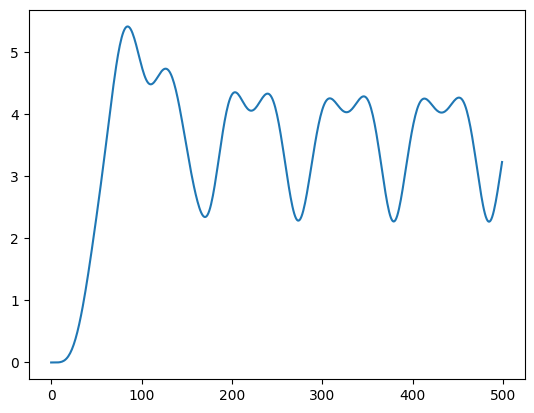

In [ ]:
x_val = x0_val
z_val = z0_val

xhist_kp = []

for i in range(len(ts) - 1):
    znext = K @ z_val + B @ U_opt[i]
    xnext_pred = Cx @ znext
    # print(f"iter {i}")
    # print(xnext)
    # print(xnext_pred)
    err_x.append(np.linalg.norm(xnext - xnext_pred))

    x_val = xnext
    z_val = znext

plt.plot(err_x)

Simulation progress: 100%|██████████| 200/200 [00:00<00:00, 13435.53it/s]


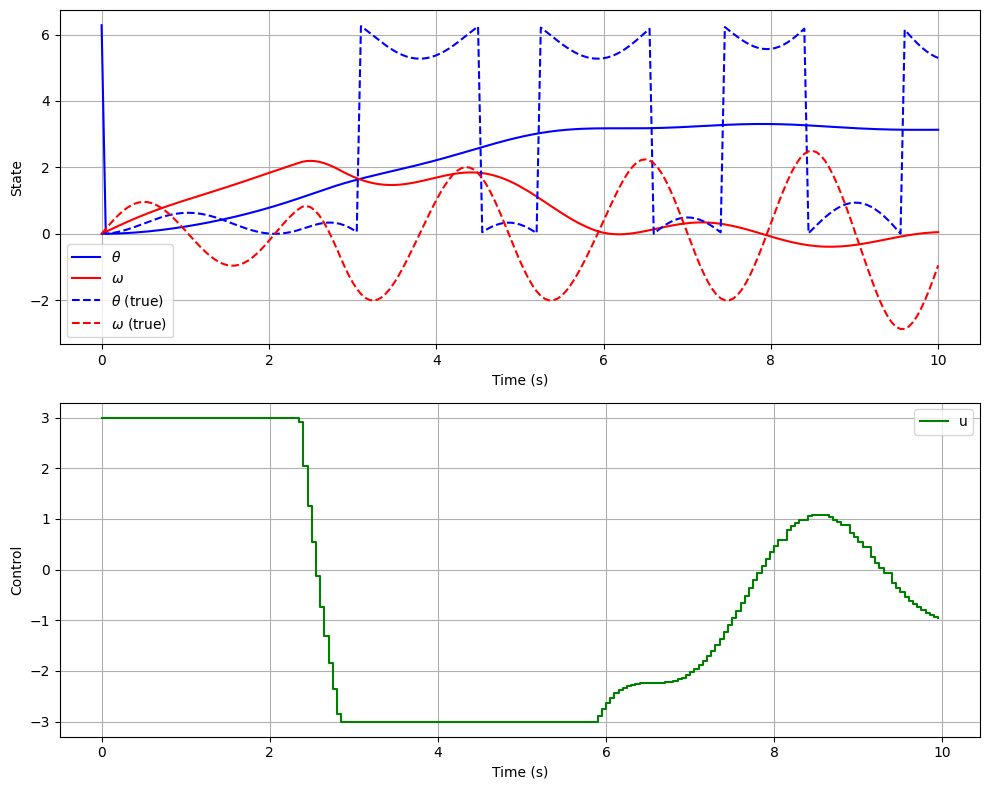

In [128]:
pendulum = Pendulum(Pendulum.Params(g=g, l=l, m=m))
ts, xhist, uhist = simulate(
    sys=pendulum,
    tf=tf,
    dt=dt,
    u=lambda t, xs: U_opt[int(t / dt)],
    x0=x0_val
)

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(ts, angle_wrap(X_opt[:, 0], "0:2pi"), label=r'$\theta$', c='blue')
ax[0].plot(ts, X_opt[:, 1], label=r'$\omega$', c='red')

ax[0].plot(ts, angle_wrap(xhist[:, 0], "0:2pi"), '--', label=r'$\theta$ (true)', c='blue')
ax[0].plot(ts, xhist[:, 1], '--', label=r'$\omega$ (true)', c='red')

ax[0].legend()
ax[0].grid(True)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('State')

ax[1].step(ts[:-1], uhist, label='u', where='post', c='green')
ax[1].legend()
ax[1].grid(True)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Control')

plt.tight_layout()
plt.show()

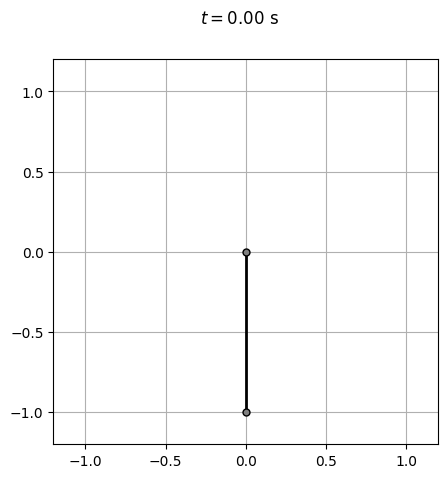

In [112]:
# Render the simulation
fig, ax = plt.subplots(figsize=(5, 5))
ax.grid(True)
ax.set_aspect('equal')

env = PlotEnvironment(fig, ax)
env.add_element(Pendulum.PlotElement(env, pendulum))
ani = env.render(t_range=(0, tf), fps=30)

HTML(ani.to_html5_video())